<a href="https://colab.research.google.com/github/clovisdanielss/Colab-Projects/blob/main/sentiment-prediction/Review_Sentiment_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NLP Example

In this notebook we'll experiment and train a NLP model to predict sentiment of products reviews.

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
small_dataset = pd.read_csv('https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
small_dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [15]:
small_dataset.text

0       So there is no way for me to plug it in here i...
1                              Good case Excellent value.
2                                  Great for the jawbone.
3       Tied to charger for conversations lasting more...
4                                       The mic is great.
                              ...                        
1987    I think food should have flavor and texture an...
1988                             Appetite instantly gone.
1989    Overall I was not impressed and would not go b...
1990    The whole experience was underwhelming and I t...
1991    Then as if I hadn't wasted enough of my life t...
Name: text, Length: 1992, dtype: object

In [16]:
small_tokenizer = Tokenizer()
small_tokenizer.fit_on_texts(small_dataset.text)
len(small_tokenizer.word_index)

3260

In [17]:
small_sequences = small_tokenizer.texts_to_sequences(small_dataset.text)
small_padded = pad_sequences(small_sequences)
small_padded

array([[   0,    0,    0, ...,  112,    4, 1428],
       [   0,    0,    0, ...,  109,   86,  396],
       [   0,    0,    0, ...,   12,    1,  731],
       ...,
       [   0,    0,    0, ...,   11,   59,   39],
       [   0,    0,    0, ...,  245,  242,   38],
       [   0,    0,    0, ...,  604,    1,  374]], dtype=int32)

In [18]:
tf.random.set_seed(42)
batch_size = 32
small_train = tf.data.Dataset.from_tensor_slices((small_padded, small_dataset.sentiment.to_numpy())).batch(batch_size)

In [19]:
len(list(small_train)),len(list(small_train))*batch_size,small_dataset.text.to_numpy().shape

(63, 2016, (1992,))

Let's check how a simple nlp model behaves without any data preparation. 

#### Our first model

In [20]:
small_model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(small_tokenizer.word_index)+1,64,input_length=small_padded.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

small_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5, monitor="loss")

small_model.fit(small_train, epochs=10, callbacks=[stop])

Epoch 1/10
63/63 [==============================] - 12s 167ms/step - loss: 0.6820 - accuracy: 0.5542
Epoch 2/10
63/63 [==============================] - 10s 165ms/step - loss: 0.5872 - accuracy: 0.7495
Epoch 3/10
63/63 [==============================] - 11s 177ms/step - loss: 0.3905 - accuracy: 0.8559
Epoch 4/10
63/63 [==============================] - 11s 167ms/step - loss: 0.1574 - accuracy: 0.9799
Epoch 5/10
63/63 [==============================] - 11s 167ms/step - loss: 0.0645 - accuracy: 0.9955
Epoch 6/10
63/63 [==============================] - 10s 166ms/step - loss: 0.0434 - accuracy: 0.9980
Epoch 7/10
63/63 [==============================] - 11s 170ms/step - loss: 0.0353 - accuracy: 0.9945
Epoch 8/10
63/63 [==============================] - 11s 168ms/step - loss: 0.0160 - accuracy: 0.9990
Epoch 9/10
63/63 [==============================] - 15s 227ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 10/10
63/63 [==============================] - 10s 166ms/step - loss: 0.0077 - accura

In [22]:
def predict(text, model):
  seq = tokenizer.texts_to_sequences([text])
  pad = pad_sequences(seq, small_padded.shape[1])
  pred = model.predict(pad)
  return pred

predict("I did NOT like your product", small_model)

array([[0.98519105]], dtype=float32)

Our first model seems to be fine. But It's most like overfitting. We will now split our data to check it.

In [23]:
tf.random.set_seed(42)
batch_size = 32
data_size = small_dataset.text.to_numpy().shape[0]
test_size = math.ceil(data_size/5)
train_size = data_size - test_size
small_data = tf.data.Dataset.from_tensor_slices((small_padded, small_dataset.sentiment.to_numpy())).shuffle(1000)
small_train = small_data.take(train_size).batch(batch_size)
small_test = small_data.skip(train_size).batch(batch_size)

len(list(small_train)), len(list(small_test))

(50, 13)

In [24]:
small_model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(small_tokenizer.word_index)+1,64,input_length=small_padded.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

small_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)

log = small_model.fit(small_train,validation_data=small_test, epochs=10, callbacks=[stop, best])

Epoch 1/10
50/50 [==============================] - 10s 184ms/step - loss: 0.6932 - accuracy: 0.5261 - val_loss: 0.6272 - val_accuracy: 0.7594
Epoch 2/10
50/50 [==============================] - 9s 175ms/step - loss: 0.5634 - accuracy: 0.7991 - val_loss: 0.3875 - val_accuracy: 0.9198
Epoch 3/10
50/50 [==============================] - 9s 177ms/step - loss: 0.3493 - accuracy: 0.8989 - val_loss: 0.2404 - val_accuracy: 0.9323
Epoch 4/10
50/50 [==============================] - 9s 177ms/step - loss: 0.1628 - accuracy: 0.9642 - val_loss: 0.0904 - val_accuracy: 0.9850
Epoch 5/10
50/50 [==============================] - 9s 178ms/step - loss: 0.0909 - accuracy: 0.9799 - val_loss: 0.0545 - val_accuracy: 0.9925
Epoch 6/10
50/50 [==============================] - 9s 177ms/step - loss: 0.0447 - accuracy: 0.9944 - val_loss: 0.0309 - val_accuracy: 0.9975
Epoch 7/10
50/50 [==============================] - 9s 172ms/step - loss: 0.0269 - accuracy: 0.9956 - val_loss: 0.0177 - val_accuracy: 0.9975
Epoch

In [25]:
predict("Wow, this is amazing",small_model)

array([[0.76315844]], dtype=float32)

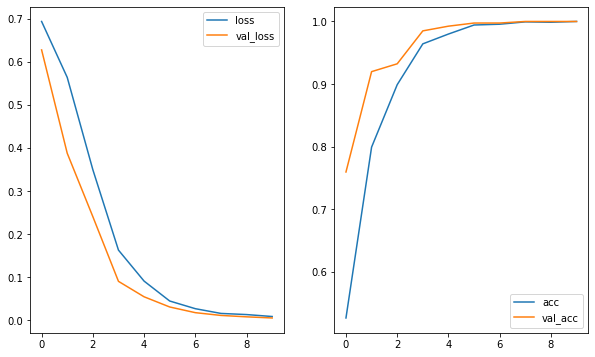

In [26]:
def plot_training(log):
  epochs = len(log.history["loss"])
  plt.figure(figsize=(10,6))
  plt.subplot(1,2,1)
  plt.plot(range(epochs), log.history["loss"], label="loss")
  plt.plot(range(epochs), log.history["val_loss"], label="val_loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(range(epochs), log.history["accuracy"], label="acc")
  plt.plot(range(epochs), log.history["val_accuracy"], label="val_acc")
  plt.legend()

plot_training(log)

Ok, It's not overfitting. But there are two things to say. 

- The dataset is too small. We just have 2000 phrases. This is way to little. 
- We know all the words in the test set. This will never happen.

So if we want to make a more real experimentation, let's try limit our word_index

In [27]:
small_tokenizer = Tokenizer(num_words=2000, oov_token="<UNK>")
small_tokenizer.fit_on_texts(small_dataset.text)
small_sequences = small_tokenizer.texts_to_sequences(small_dataset.text)
small_padded = pad_sequences(small_sequences)
small_padded.shape

(1992, 139)

Now, we only know $\frac{2}{3}$ of the words in our dataset

In [28]:
tf.random.set_seed(42)
batch_size = 32
data_size = small_dataset.text.to_numpy().shape[0]
test_size = math.ceil(data_size/5)
train_size = data_size - test_size
small_data = tf.data.Dataset.from_tensor_slices((small_padded, small_dataset.sentiment.to_numpy())).shuffle(1000)
small_train = small_data.take(train_size).batch(batch_size)
small_test = small_data.skip(train_size).batch(batch_size)

len(list(small_train)), len(list(small_test))

(50, 13)

Epoch 1/10
50/50 [==============================] - 10s 182ms/step - loss: 0.6889 - accuracy: 0.5455 - val_loss: 0.6318 - val_accuracy: 0.7068
Epoch 2/10
50/50 [==============================] - 9s 176ms/step - loss: 0.5625 - accuracy: 0.7853 - val_loss: 0.3903 - val_accuracy: 0.9073
Epoch 3/10
50/50 [==============================] - 9s 178ms/step - loss: 0.4056 - accuracy: 0.8487 - val_loss: 0.2958 - val_accuracy: 0.9248
Epoch 4/10
50/50 [==============================] - 9s 179ms/step - loss: 0.2294 - accuracy: 0.9435 - val_loss: 0.1514 - val_accuracy: 0.9599
Epoch 5/10
50/50 [==============================] - 9s 176ms/step - loss: 0.1225 - accuracy: 0.9711 - val_loss: 0.0795 - val_accuracy: 0.9825
Epoch 6/10
50/50 [==============================] - 9s 176ms/step - loss: 0.0662 - accuracy: 0.9881 - val_loss: 0.0534 - val_accuracy: 0.9900
Epoch 7/10
50/50 [==============================] - 9s 180ms/step - loss: 0.0420 - accuracy: 0.9937 - val_loss: 0.0248 - val_accuracy: 0.9975
Epoch

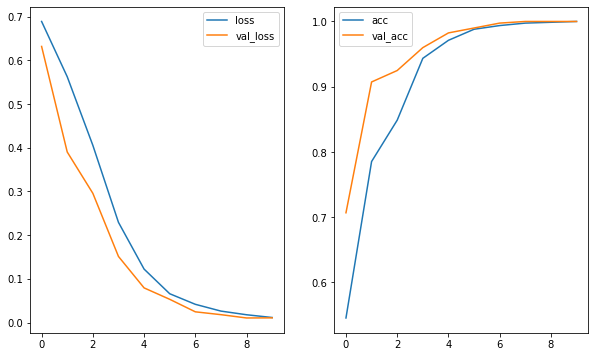

In [29]:
small_model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(small_tokenizer.word_index)+1,64,input_length=small_padded.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

small_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)

log = small_model.fit(small_train,validation_data=small_test, epochs=10, callbacks=[stop, best])
plot_training(log)

Even knowing only $\frac{2}{3}$ of our words, the results seems promissing. Lets check our words.

In [30]:
ordered_by_freq = [(key,val) for key,val in small_tokenizer.word_counts.items()]
ordered_by_freq.sort(key=lambda tup: tup[1], reverse=True)
ordered_by_freq[:20]

[('the', 1104),
 ('and', 704),
 ('i', 627),
 ('a', 456),
 ('it', 418),
 ('to', 417),
 ('is', 414),
 ('was', 385),
 ('this', 351),
 ('of', 247),
 ('not', 233),
 ('for', 231),
 ('my', 218),
 ('in', 197),
 ('with', 183),
 ('very', 180),
 ('good', 172),
 ('great', 169),
 ('phone', 165),
 ('that', 148)]

As we know, we didn't make any data preparation. So a lot of words are stop words. But as we can see, we can identify words such as:

- not
- very
- good
- great

Those words capture the essence of a good review or a bad review. If the model was still going bad, here is a couple things we could do:

- Remove stopwords from vocabulary
- Use subwords in tokenization
- Tweek the model

### Conclusion

This dataset didnt need any kind of data preparation, so It was very simple to work with it. Since we got a model working with 1.0 of accuracy in the validation data, I will call it a day and work in another dataset.

In [ ]:
#!pip install tensorflowjs
#!tensorflowjs_converter --input_format keras best.h5 ./predictor/
#from google.colab import files
#files.download("predictor/group1-shard1of1.bin")
#files.download("predictor/model.json")

In [ ]:
#import io
#import json 
#tokenizer_json = small_tokenizer.to_json()
#with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
#    f.write(json.dumps(json.loads(tokenizer_json),ensure_ascii=False))

### Trying a bigger dataset

In [31]:
import tensorflow_datasets as tfds
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_training():
  epochs = len(log.history["loss"])
  plt.figure(figsize=(10,6))
  plt.subplot(1,2,1)
  plt.plot(range(epochs), log.history["loss"], label="loss")
  plt.plot(range(epochs), log.history["val_loss"], label="val_loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(range(epochs), log.history["accuracy"], label="acc")
  plt.plot(range(epochs), log.history["val_accuracy"], label="val_acc")
  plt.legend()

In [32]:
from zipfile import ZipFile
from urllib.request import urlopen 

url = urlopen("https://dl.fbaipublicfiles.com/glue/data/SST-2.zip")
with open("dataset.zip", "wb") as sst:
  sst.write(url.read())

In [33]:
train_data = pd.read_csv(ZipFile("./dataset.zip").open("SST-2/train.tsv"), sep="\t")
test_data = pd.read_csv(ZipFile("./dataset.zip").open("SST-2/test.tsv"), sep="\t")
train_data

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


In [34]:
test_data

,index,sentence
0,0,uneasy mishmash of styles and genres .
1,1,this film 's relationship to actual tension is...
2,2,"by the end of no such thing the audience , lik..."
3,3,director rob marshall went out gunning to make...
4,4,lathan and diggs have considerable personal ch...
...,...,...
1816,1816,"it risks seeming slow and pretentious , becaus..."
1817,1817,take care of my cat offers a refreshingly diff...
1818,1818,davis has filled out his cast with appealing f...
1819,1819,it represents better-than-average movie-making...


In [35]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(train_data.sentence)
len(tokenizer.index_word)

13823

Okay, so our dataset for training has 67349 sentences. And 13823 unique words. Thats a lot more than the previous dataset.

We will now split the training data into validation and training. 

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_data.sentence, train_data.label, random_state=42, test_size=.2)

In [37]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((53879,), (13470,), (53879,), (13470,))

### Why do we split train/valid first ?

We splited first because we want to fit our tokenizer only in the training data to our validation set be as unknown as our test set.
When we decide our final model we'll train it on our full train_dataset.

In [38]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(x_train)
len(tokenizer.index_word)

13704

In [39]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq)
x_train_pad.shape

(53879, 49)

So our max length in our x_train was 49. We Will use that to garantee that out x_valid_pad has the same length

In [40]:
x_valid_seq = tokenizer.texts_to_sequences(x_valid)
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

(13470, 49)

Epoch 1/10
842/842 [==============================] - 73s 85ms/step - loss: 0.3872 - accuracy: 0.8191 - val_loss: 0.2596 - val_accuracy: 0.9019
Epoch 2/10
842/842 [==============================] - 58s 69ms/step - loss: 0.1817 - accuracy: 0.9349 - val_loss: 0.2577 - val_accuracy: 0.9079
Epoch 3/10
842/842 [==============================] - 58s 69ms/step - loss: 0.1306 - accuracy: 0.9550 - val_loss: 0.2617 - val_accuracy: 0.9108
Epoch 4/10
842/842 [==============================] - 58s 69ms/step - loss: 0.1037 - accuracy: 0.9654 - val_loss: 0.2757 - val_accuracy: 0.9077
Epoch 5/10
842/842 [==============================] - 58s 69ms/step - loss: 0.0883 - accuracy: 0.9702 - val_loss: 0.2802 - val_accuracy: 0.9131
Epoch 6/10
842/842 [==============================] - 57s 68ms/step - loss: 0.0754 - accuracy: 0.9735 - val_loss: 0.2837 - val_accuracy: 0.9111
Epoch 7/10
842/842 [==============================] - 94s 112ms/step - loss: 0.0699 - accuracy: 0.9759 - val_loss: 0.2984 - val_accuracy

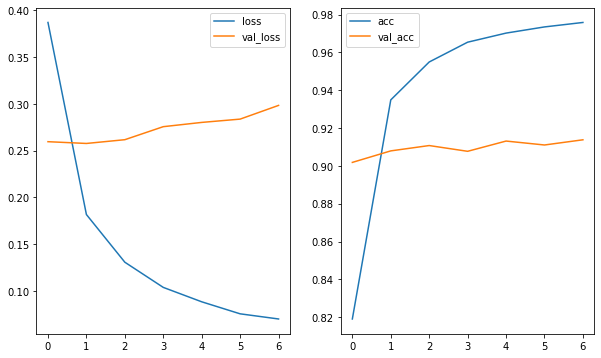

In [41]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=x_train_pad.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)
batch_size=64
log = model.fit(x=x_train_pad, y=y_train,validation_data=(x_valid_pad, y_valid), epochs=10, callbacks=[stop, best], batch_size=batch_size, steps_per_epoch=math.ceil(x_train_pad.shape[0]/batch_size), validation_steps=math.ceil(x_valid_pad.shape[0]/batch_size))
plot_training()

### Comparisons 

#### The model trained on SST2 vs the small dataset.

In [43]:
x_valid_seq = tokenizer.texts_to_sequences(small_dataset.text.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model.evaluate(x= x_valid_pad, y=small_dataset.sentiment.to_numpy())

63/63 [==============================] - 2s 21ms/step - loss: 0.7778 - accuracy: 0.7686


[0.7777805328369141, 0.7685742974281311]

#### The small dataset only

Just to remember that it's overffited. Now we will prove it

In [47]:
x_valid_seq = small_tokenizer.texts_to_sequences(small_dataset.text.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=small_padded.shape[1])
x_valid_pad.shape
small_model.evaluate(x= x_valid_pad, y=small_dataset.sentiment.to_numpy())

63/63 [==============================] - 2s 34ms/step - loss: 0.0151 - accuracy: 0.9980


[0.015133506618440151, 0.9979919791221619]

#### The small model vs the SST2 dataset

In [49]:
x_valid_seq = small_tokenizer.texts_to_sequences(x_valid.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=small_padded.shape[1])
x_valid_pad.shape
small_model.evaluate(x= x_valid_pad, y=y_valid.to_numpy())

421/421 [==============================] - 7s 17ms/step - loss: 0.9396 - accuracy: 0.5889


[0.9396033883094788, 0.5888641476631165]

We can see that we achieve an accuracy of 58%. For a two-class problem, this is bad. Very bad. So our model trained in the SST2 dataset perform better in unkown data than the small model

### Lets try to use LSTM

Epoch 1/10
842/842 [==============================] - 33s 31ms/step - loss: 0.3682 - accuracy: 0.8305 - val_loss: 0.2630 - val_accuracy: 0.8950
Epoch 2/10
842/842 [==============================] - 25s 29ms/step - loss: 0.1943 - accuracy: 0.9255 - val_loss: 0.2402 - val_accuracy: 0.9110
Epoch 3/10
842/842 [==============================] - 25s 29ms/step - loss: 0.1389 - accuracy: 0.9486 - val_loss: 0.2490 - val_accuracy: 0.9139
Epoch 4/10
842/842 [==============================] - 25s 30ms/step - loss: 0.1073 - accuracy: 0.9602 - val_loss: 0.2464 - val_accuracy: 0.9201
Epoch 5/10
842/842 [==============================] - 25s 29ms/step - loss: 0.0851 - accuracy: 0.9666 - val_loss: 0.2871 - val_accuracy: 0.9209
Epoch 6/10
842/842 [==============================] - 25s 29ms/step - loss: 0.0693 - accuracy: 0.9719 - val_loss: 0.2983 - val_accuracy: 0.9229
Epoch 7/10
842/842 [==============================] - 25s 29ms/step - loss: 0.0575 - accuracy: 0.9760 - val_loss: 0.3139 - val_accuracy:

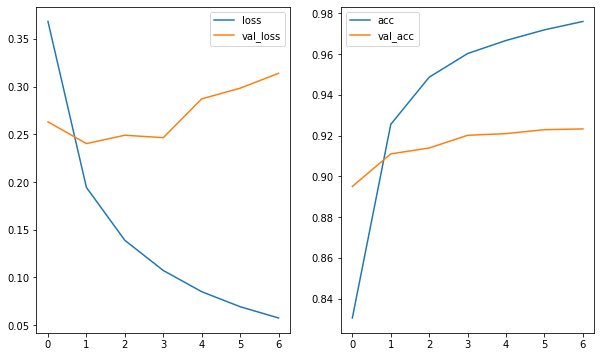

In [50]:
x_valid_seq = tokenizer.texts_to_sequences(x_valid)
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=x_train_pad.shape[1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)
batch_size=64
log = model.fit(x=x_train_pad, y=y_train,validation_data=(x_valid_pad, y_valid), epochs=10, callbacks=[stop, best], batch_size=batch_size, steps_per_epoch=math.ceil(x_train_pad.shape[0]/batch_size), validation_steps=math.ceil(x_valid_pad.shape[0]/batch_size))
plot_training()

In [51]:
x_valid_seq = tokenizer.texts_to_sequences(small_dataset.text.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model.evaluate(x= x_valid_pad, y=small_dataset.sentiment.to_numpy())

63/63 [==============================] - 2s 12ms/step - loss: 0.7021 - accuracy: 0.7902


[0.7021204233169556, 0.7901606559753418]

When using LSTM we achieved an accuracy of 79% on unknown data, which is way better than 76%.

In [55]:
stopwords = pd.read_csv("https://raw.githubusercontent.com/Alir3z4/stop-words/master/english.txt", header=None)
stopwords[0]

0         'll
1        'tis
2       'twas
3         've
4          10
        ...  
1293        z
1294       za
1295     zero
1296       zm
1297       zr
Name: 0, Length: 1298, dtype: object

In [59]:
'i' in set(stopwords[0])

True

In [75]:
def remove_stopwords(word):
  word_array = word.split(' ')
  return " ".join([w.lower() for w in word_array if w.lower() not in set(stopwords[0])])

x_train_nostopwords = x_train.map(remove_stopwords)
x_train_nostopwords

65374    lacks inspiration original bloated plot stretc...
14599                film freshness , imagination insight 
46387                                alienating involving 
27872    creative animation ` rendered ' pixar 's indus...
40668                       winning , heartwarming yarn . 
                               ...                        
37194                              provocative conclusion 
6265         action film disguised war tribute disgusting 
54886                   absurd lengths duck issues raises 
860                                   perfect performance 
15795                              constantly pulling rug 
Name: sentence, Length: 53879, dtype: object

In [62]:
x_valid_nostopwords = x_valid.map(remove_stopwords)
x_valid_nostopwords

66730    outtakes characters forget lines utter ` uhhh ...
29890                                    enigma well-made 
45801    ) stoked film human infidelity happenstance to...
29352                     closest experience space travel 
19858                                         lose luster 
                               ...                        
34702                                          nice album 
23754                                                     
58408                                                 n't 
5637      beautifully movie sacrificing integrity opera . 
26351    love overinflated mythology recognizes moviego...
Name: sentence, Length: 13470, dtype: object

In [63]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(x_train_nostopwords)
len(tokenizer.index_word)

13193

In [64]:
x_train_seq = tokenizer.texts_to_sequences(x_train_nostopwords)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq)
x_train_pad.shape

(53879, 28)

In [65]:
x_valid_seq = tokenizer.texts_to_sequences(x_valid_nostopwords)
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

(13470, 28)

We can see that using remove_stopwords we removed a lot of dimentionality. We now are working with 28 columns. 

Epoch 1/10
842/842 [==============================] - 23s 23ms/step - loss: 0.3948 - accuracy: 0.8179 - val_loss: 0.2904 - val_accuracy: 0.8817
Epoch 2/10
842/842 [==============================] - 17s 20ms/step - loss: 0.2373 - accuracy: 0.9042 - val_loss: 0.2797 - val_accuracy: 0.8892
Epoch 3/10
842/842 [==============================] - 17s 20ms/step - loss: 0.1933 - accuracy: 0.9220 - val_loss: 0.2763 - val_accuracy: 0.8967
Epoch 4/10
842/842 [==============================] - 17s 20ms/step - loss: 0.1622 - accuracy: 0.9343 - val_loss: 0.2736 - val_accuracy: 0.9019
Epoch 5/10
842/842 [==============================] - 17s 20ms/step - loss: 0.1374 - accuracy: 0.9423 - val_loss: 0.3062 - val_accuracy: 0.9014
Epoch 6/10
842/842 [==============================] - 17s 20ms/step - loss: 0.1199 - accuracy: 0.9477 - val_loss: 0.3148 - val_accuracy: 0.9027
Epoch 7/10
842/842 [==============================] - 18s 21ms/step - loss: 0.1070 - accuracy: 0.9515 - val_loss: 0.3700 - val_accuracy:

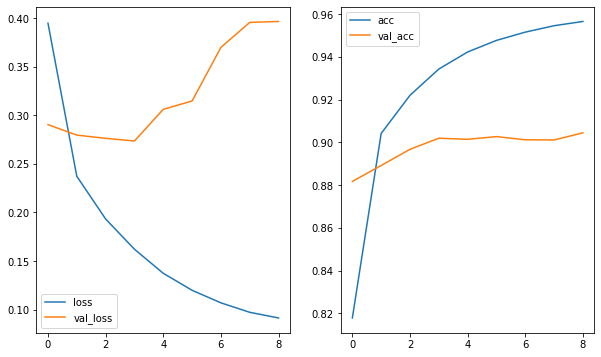

In [66]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=x_train_pad.shape[1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)
batch_size=64
log = model.fit(x=x_train_pad, y=y_train,validation_data=(x_valid_pad, y_valid), epochs=10, callbacks=[stop, best], batch_size=batch_size, steps_per_epoch=math.ceil(x_train_pad.shape[0]/batch_size), validation_steps=math.ceil(x_valid_pad.shape[0]/batch_size))
plot_training()

Let's see how do this model performs in unknown data without remove stopwords.

In [67]:
x_valid_seq = tokenizer.texts_to_sequences(small_dataset.text.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model.evaluate(x= x_valid_pad, y=small_dataset.sentiment.to_numpy())

63/63 [==============================] - 2s 9ms/step - loss: 1.2370 - accuracy: 0.6767


[1.2370197772979736, 0.676706850528717]

Ok it's expected to perform worse because of lots of UNK words that are now in the sencenteces. 
Now, let's try to remove stopwords first. 

In [76]:
small_dataset_nostopwords = small_dataset.text.map(remove_stopwords)

x_valid_seq = tokenizer.texts_to_sequences(small_dataset_nostopwords.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model.evaluate(x= x_valid_pad, y=small_dataset.sentiment.to_numpy())

63/63 [==============================] - 0s 7ms/step - loss: 1.3330 - accuracy: 0.6762


[1.3329819440841675, 0.6762048006057739]

In [78]:
small_dataset_nostopwords

0                                         plug converter.
1                                        excellent value.
2                                                jawbone.
3       tied charger conversations lasting 45 minutes....
4                                              mic great.
                              ...                        
1987                         food flavor texture lacking.
1988                             appetite instantly gone.
1989                                      impressed back.
1990           experience underwhelming ninja sushi time.
1991    wasted life poured salt wound drawing time bri...
Name: text, Length: 1992, dtype: object

So why when using stopwords we got an better performance than without it ? 

Acually, the problem is in our stopwords set. If you look it, you will see words that may be useful for sentiment detection. 
Words like "problem", and words that indicated intensity like "most", "least"

So we need to take care when removing stopwords. 

### Last model

Our last model will be the LSTM model trained in the bigger dataset without removing the stopwords.

Epoch 1/10
842/842 [==============================] - 29s 30ms/step - loss: 0.3835 - accuracy: 0.8237 - val_loss: 0.2680 - val_accuracy: 0.8929
Epoch 2/10
842/842 [==============================] - 24s 29ms/step - loss: 0.1995 - accuracy: 0.9240 - val_loss: 0.2432 - val_accuracy: 0.9072
Epoch 3/10
842/842 [==============================] - 24s 29ms/step - loss: 0.1435 - accuracy: 0.9475 - val_loss: 0.2470 - val_accuracy: 0.9139
Epoch 4/10
842/842 [==============================] - 24s 29ms/step - loss: 0.1095 - accuracy: 0.9597 - val_loss: 0.2453 - val_accuracy: 0.9203
Epoch 5/10
842/842 [==============================] - 24s 29ms/step - loss: 0.0866 - accuracy: 0.9674 - val_loss: 0.2825 - val_accuracy: 0.9216
Epoch 6/10
842/842 [==============================] - 24s 29ms/step - loss: 0.0684 - accuracy: 0.9726 - val_loss: 0.2993 - val_accuracy: 0.9234
Epoch 7/10
842/842 [==============================] - 25s 29ms/step - loss: 0.0581 - accuracy: 0.9763 - val_loss: 0.3282 - val_accuracy:

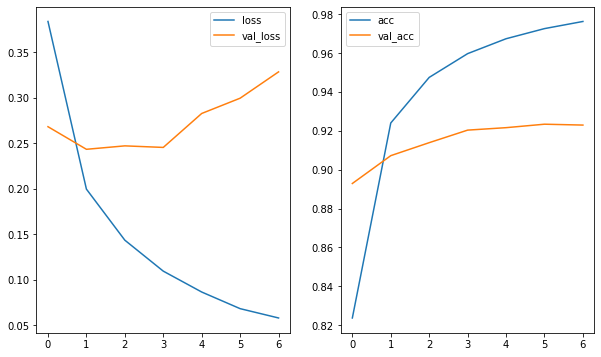

In [79]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(x_train)
len(tokenizer.index_word)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq)
x_train_pad.shape

x_valid_seq = tokenizer.texts_to_sequences(x_valid)
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=x_train_pad.shape[1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)
batch_size=64
log = model.fit(x=x_train_pad, y=y_train,validation_data=(x_valid_pad, y_valid), epochs=10, callbacks=[stop, best], batch_size=batch_size, steps_per_epoch=math.ceil(x_train_pad.shape[0]/batch_size), validation_steps=math.ceil(x_valid_pad.shape[0]/batch_size))
plot_training()

In [80]:
x_valid_seq = tokenizer.texts_to_sequences(small_dataset.text.to_numpy())
x_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(x_valid_seq, maxlen=x_train_pad.shape[1])
x_valid_pad.shape

model.evaluate(x= x_valid_pad, y=small_dataset.sentiment.to_numpy())

63/63 [==============================] - 2s 12ms/step - loss: 0.7220 - accuracy: 0.7947


[0.721989631652832, 0.7946786880493164]

In [85]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras best.h5 ./predictor/
#from google.colab import files
#files.download("predictor/group1-shard1of1.bin")
#files.download("predictor/model.json")

     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 462 kB 11.2 MB/s 


In [84]:
import io
import json 
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(json.loads(tokenizer_json),ensure_ascii=False))